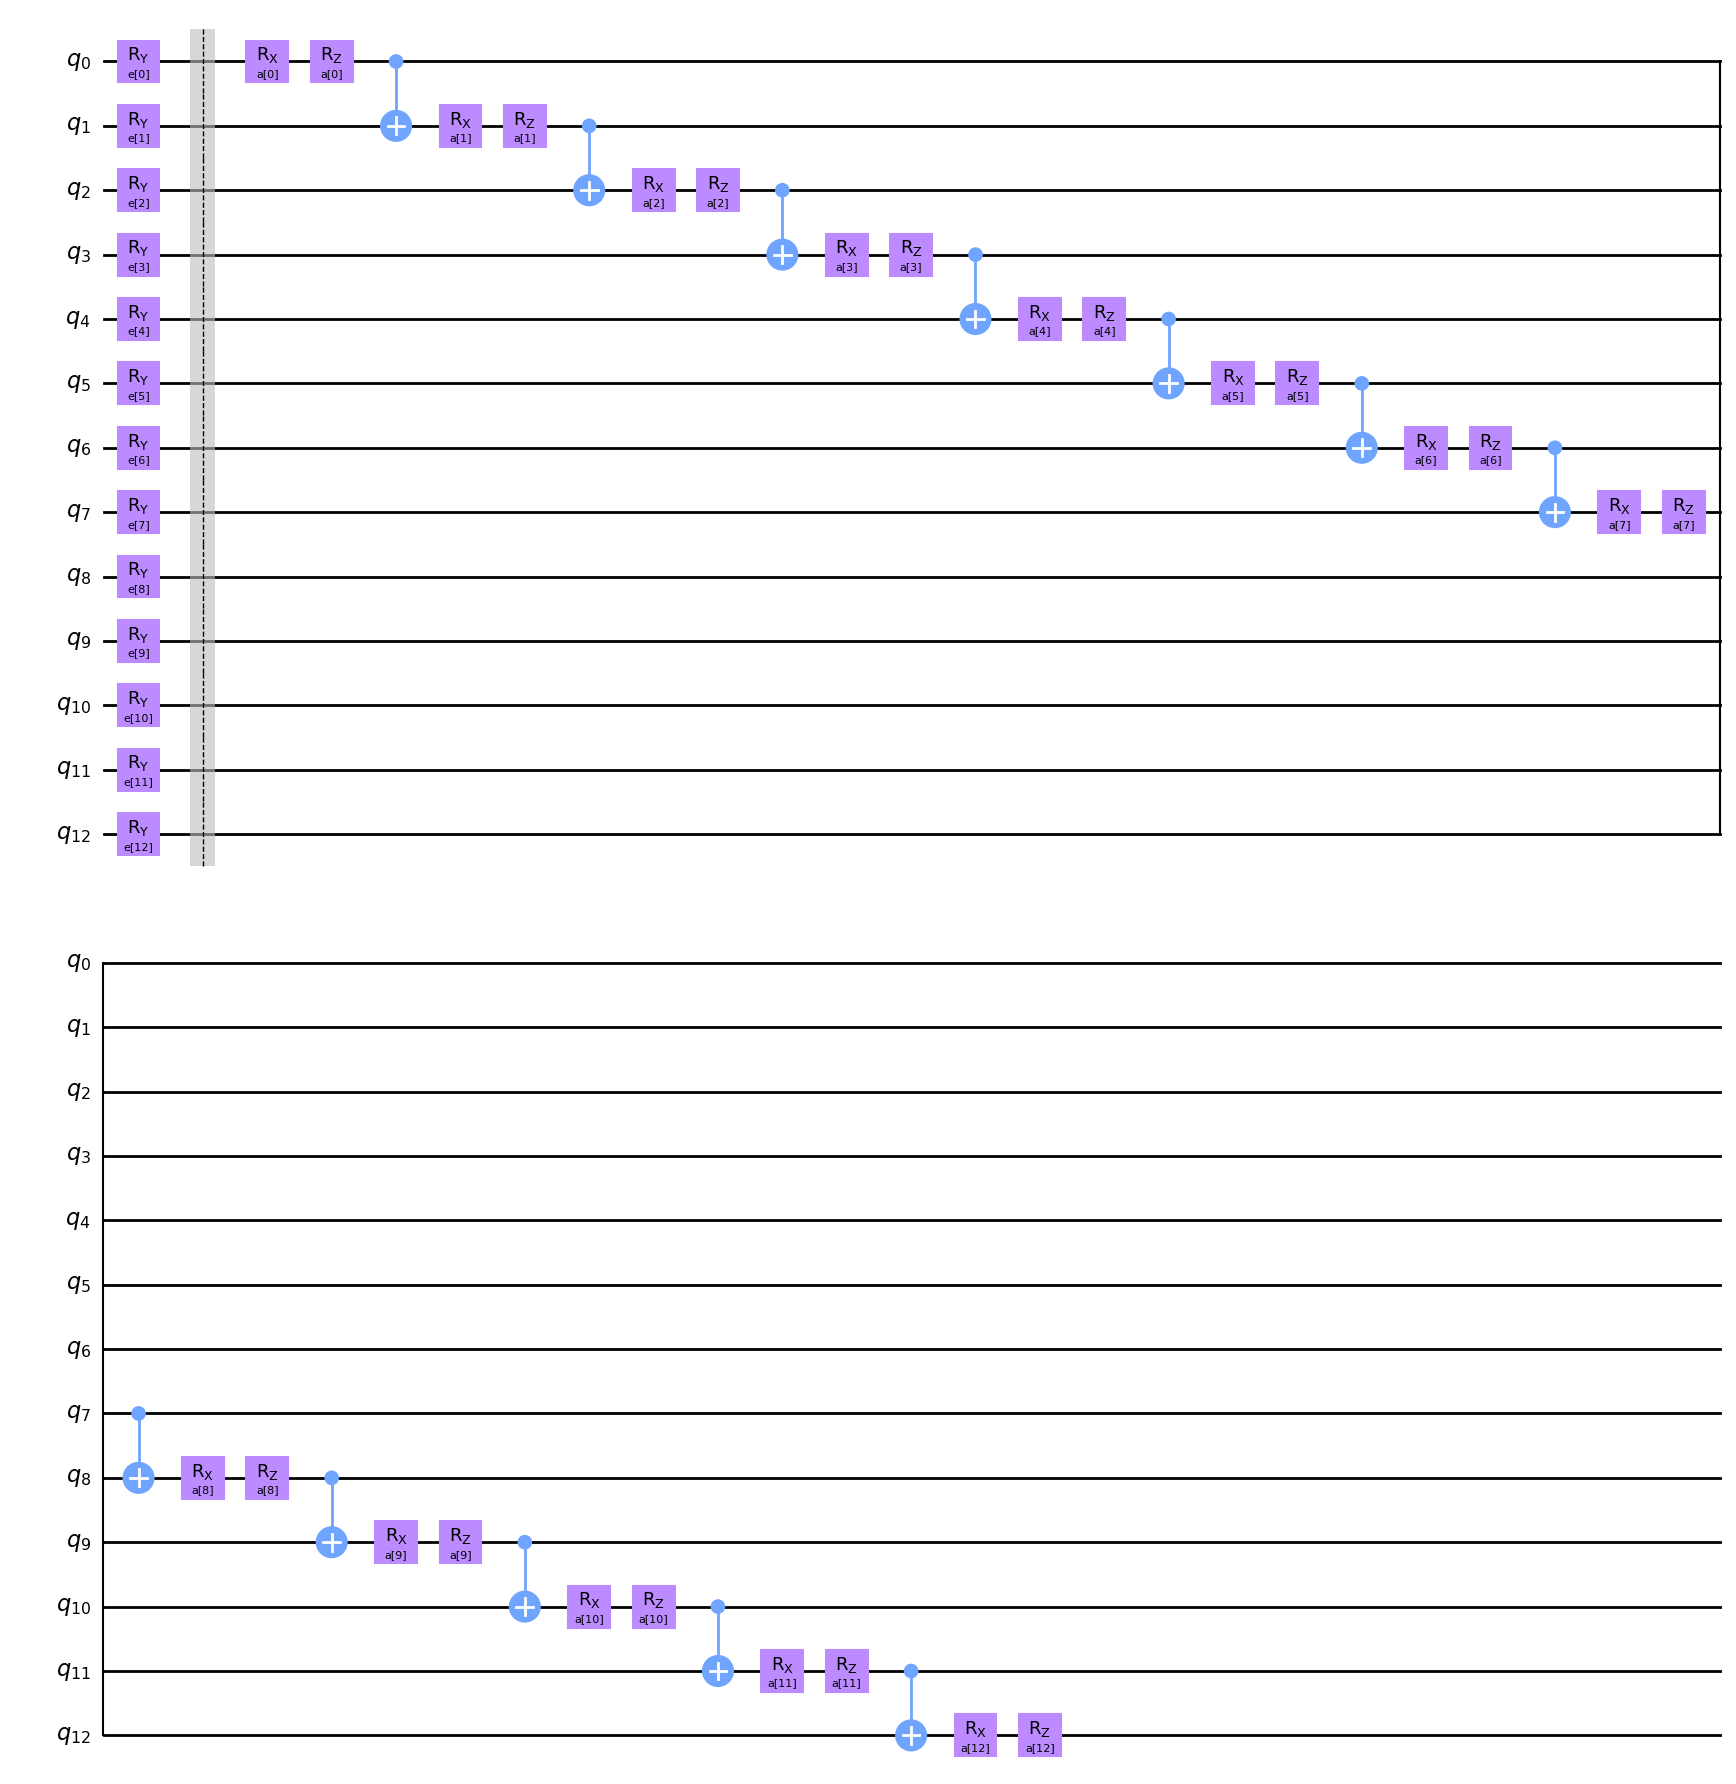

In [12]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

from IPython.display import clear_output

from qiskit import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp
from qiskit.opflow import StateFn
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA, GSLS

# data_iris = load_iris()
# x = data_iris.data
# y = data_iris.target

data_wine = load_wine()
x = data_wine.data
y = data_wine.target

# Buat binary class
# indexes = np.array([i for (i, s) in enumerate(y) if (s == 0 or s == 1)])
# x = x[indexes]
# y = 2 * y[indexes] - 1

indexes = np.array([i for (i, label) in enumerate(y) if label in [0, 1]])
x = x[indexes]
y = 2 * (y[indexes] == 0) - 1  # Convert labels to -1 and 1 (class 0 becomes -1, class 1 remains 1)

# Scaler

x = MinMaxScaler().fit_transform(x)

# Split

algorithm_globals.random_seed = 123
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.16, random_state=algorithm_globals.random_seed)

# Ofv

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Parameter
num_qubits       = x.shape[1]
simulator        = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(simulator)
optimizer        = GSLS(maxiter=64)                             # Dapat dioptimisasi
param_encoding   = ParameterVector('e', num_qubits)                
param_ansatz     = ParameterVector('a', num_qubits)                
# observable       = PauliSumOp.from_list([("XYZI", 1.0)])
observable       = PauliSumOp.from_list([(''.join('I' for _ in range(num_qubits)), 1.0)])

qc = QuantumCircuit(num_qubits)

# Encoding
for i in range (num_qubits):
    # qc.h(i)
    qc.ry(param_encoding[i], i)
    
qc.barrier()

# Ansatz
# for i in range (num_qubits):
#     qc.ry(param_ansatz[i], i)
#     qc.rz(param_ansatz[i], i)
# for i in range(num_qubits-1): 
#     qc.cx(i, i+1)
for i in range (num_qubits):
    qc.rx(param_ansatz[i], i)
    # qc.ry(param_ansatz[i], i)
    qc.rz(param_ansatz[i], i)
    if i < num_qubits - 1:
        qc.cx(i, i+1)
# for i in range(num_qubits-1): 
#     qc.cx(i, i+1)
# qc.cx(3, 0)

# QNN classifier
qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(qc)
estimator_qnn    = EstimatorQNN(
    circuit=qc, 
    observables=observable, 
    input_params=param_encoding, 
    weight_params=param_ansatz
)
qnn = NeuralNetworkClassifier(
    estimator_qnn, optimizer=optimizer, loss='squared_error', callback=callback_graph
)

# Plot sirkuit
qc.draw(output='mpl', style="clifford")


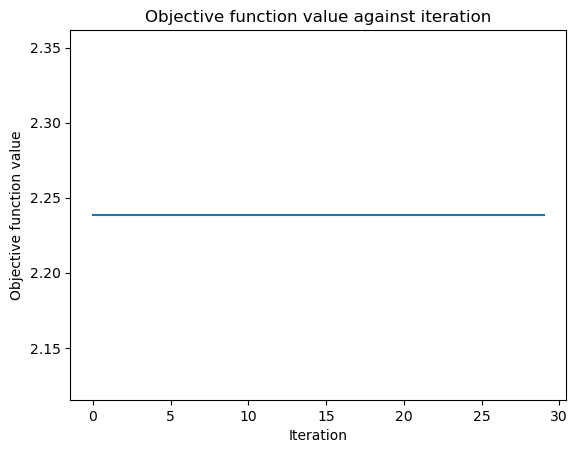

Training time: 4 seconds
TRAIN:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        61
           1       0.44      1.00      0.61        48

    accuracy                           0.44       109
   macro avg       0.22      0.50      0.31       109
weighted avg       0.19      0.44      0.27       109

TEST:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.52      1.00      0.69        11

    accuracy                           0.52        21
   macro avg       0.26      0.50      0.34        21
weighted avg       0.27      0.52      0.36        21



In [20]:
# training timer
start   = time.time()
qnn.fit(x_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

# result
y_pred_tr = qnn.predict(x_train)
y_pred_ts = qnn.predict(x_test)

print('TRAIN:')
report_tr      = classification_report(y_train, y_pred_tr, zero_division=0)
print(report_tr)

print('TEST:')
report_ts      = classification_report(y_test, y_pred_ts, zero_division=0)
print(report_ts)

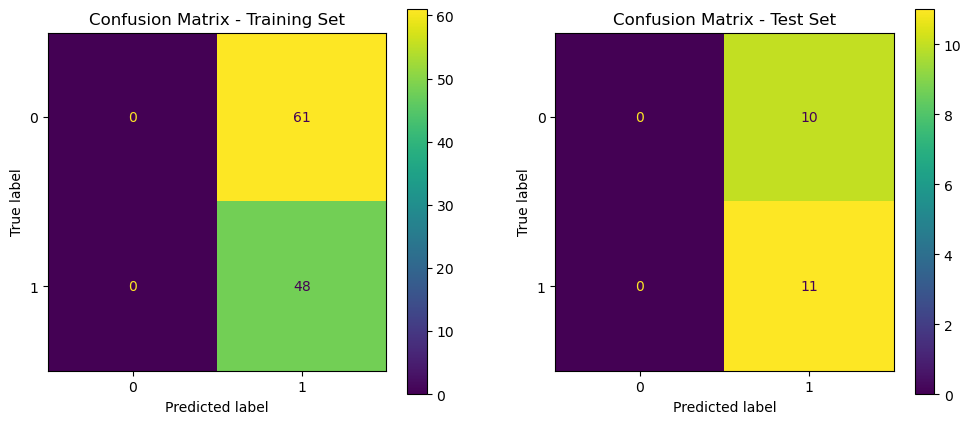

In [22]:
cm_tr   = confusion_matrix(y_train, y_pred_tr)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
disp_tr.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Set')

cm_ts   = confusion_matrix(y_test, y_pred_ts)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)
disp_ts.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Set')

plt.show()

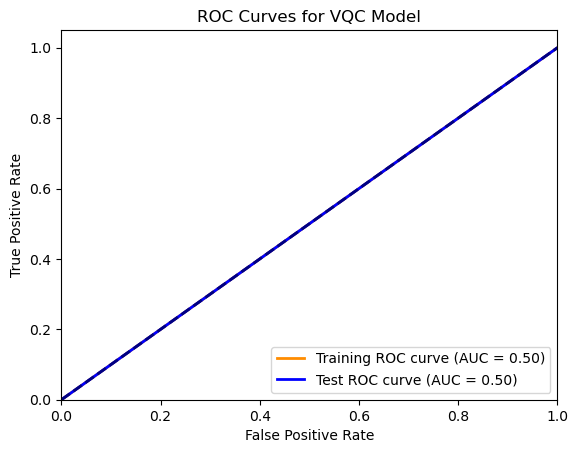

In [24]:
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_tr)
roc_auc_tr        = auc(fpr_tr, tpr_tr)
fpr_ts, tpr_ts, _ = roc_curve(y_test, y_pred_ts)
roc_auc_ts        = auc(fpr_ts, tpr_ts)

plt.figure()
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_tr:0.2f})')
plt.plot(fpr_ts, tpr_ts, color='blue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_ts:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for VQC Model')
plt.legend(loc="lower right")
plt.show()